# MED-PC Extracting the Recording Data and Metadata

## Importing the Python Libraries

In [1]:
import sys
import glob
from collections import defaultdict
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from moviepy.editor import *
from datetime import datetime
from IPython.display import Video
from pathlib import Path

In [2]:
from medpc2excel.medpc_read import medpc_read
import cv2
import h5py
import numpy as np
from functools import reduce
from scipy.interpolate import interp1d

# Getting Tone Times

In [3]:
tone_start_df = pd.read_excel("./data/reward_comp_tone_sleap_frames.xlsx")

- Getting the file name as opposed to the whole path

In [4]:
tone_start_df["File Name"] = tone_start_df["File Name"].apply(lambda x: x.split(".")[0])

- Getting the subject name from the file name

In [5]:
tone_start_df["subj_1"] = tone_start_df["File Name"].apply(lambda x: sorted(x.split("_")[-1].split(".")[0].split("v"))[0].replace("-", ".").strip())

In [6]:
tone_start_df["subj_2"] = tone_start_df["File Name"].apply(lambda x: sorted(x.split("_")[-1].split(".")[0].split("v"))[1].replace("-", ".").strip())

- Creating a tuple of the subject names so we can cross reference data sets

In [7]:
tone_start_df["all_subj"] = tone_start_df.apply(lambda x: tuple(sorted([x["subj_1"], x["subj_2"]])) , axis=1)

In [8]:
tone_start_df = tone_start_df[tone_start_df["Frame Start"].astype(str).str.isnumeric()]

In [9]:
# ITIs from MED-PC code
all_itis = [80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 120, 80, 95, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 90, 80, 90, 100, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90 ]

In [10]:
# Converting the seconds into frames
all_itis = [num * 30 for num in all_itis]

- Function that let's you cumuatively add a list of items

In [11]:
def get_running_total(lst):
    """
    """
    return reduce(lambda acc, x: acc + [acc[-1] + x] if acc else [x], lst, [])

In [12]:
tone_start_df["all_tone_frame"] = tone_start_df.apply(lambda row: get_running_total([row["Frame Start"]] + all_itis), axis=1)

In [13]:
tone_start_df.head()

,File Name,Frame Start,FPS,Strain,subj_1,subj_2,all_subj,all_tone_frame
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,1.1,1.2,"(1.1, 1.2)","[2135, 4535, 7235, 9635, 11885, 14885, 17735, ..."
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,1.3,1.4,"(1.3, 1.4)","[2123, 4523, 7223, 9623, 11873, 14873, 17723, ..."
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2.1,2.2,"(2.1, 2.2)","[2125, 4525, 7225, 9625, 11875, 14875, 17725, ..."
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,2.2,2.4,"(2.2, 2.4)","[2138, 4538, 7238, 9638, 11888, 14888, 17738, ..."
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,2.1,2.3,"(2.1, 2.3)","[2127, 4527, 7227, 9627, 11877, 14877, 17727, ..."


# Get Coordinates of all the corners

- Reading in all the files with the corner coordinate and the pose tracking"

In [14]:
all_corner_h5 = glob.glob("/scratch/back_up/dominance_strain_comparison/proc/distance_calculation/corner_labeling/*/*/*.corner.h5")

In [15]:
all_pose_estimation_h5 = glob.glob("/scratch/back_up/dominance_strain_comparison/proc/distance_calculation/h5/*/*/*.h5")

In [16]:
len(all_corner_h5)

33

In [17]:
len(all_pose_estimation_h5)

33

- Matching all the video file names to the corresponding corner and pose tracking coordinate file

In [18]:
file_name_to_corner = {item.split("/")[-1].split(".")[0].strip(): item for item in all_corner_h5}

In [19]:
file_name_to_pose_estimation = {item.split("/")[-1].split(".")[0].strip(): item for item in all_pose_estimation_h5}

In [20]:
tone_start_df["corner_file"] = tone_start_df["File Name"].map(file_name_to_corner)
tone_start_df["pose_estimation_file"] = tone_start_df["File Name"].map(file_name_to_pose_estimation)

In [21]:
tone_start_df.head()

,File Name,Frame Start,FPS,Strain,subj_1,subj_2,all_subj,all_tone_frame,corner_file,pose_estimation_file
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,1.1,1.2,"(1.1, 1.2)","[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,1.3,1.4,"(1.3, 1.4)","[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2.1,2.2,"(2.1, 2.2)","[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,2.2,2.4,"(2.2, 2.4)","[2138, 4538, 7238, 9638, 11888, 14888, 17738, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,2.1,2.3,"(2.1, 2.3)","[2127, 4527, 7227, 9627, 11877, 14877, 17727, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...


- Function that gets the SLEAP data

In [22]:
def get_sleap_coordinates(filename):
    """
    """
    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]
        track_names = [n.decode() for n in f["track_names"][:]]
    return locations, node_names, track_names

In [23]:
corner_node_names = get_sleap_coordinates(all_corner_h5[0])[1]

In [24]:
corner_node_names

['box_bottom_left',
 'reward_port',
 'box_bottom_right',
 'box_top_left',
 'box_top_right']

- Getting the coordinates of each corner and the reward port

In [25]:
for index, node in enumerate(corner_node_names):
    tone_start_df["{}_coordinates".format(node)] = tone_start_df["corner_file"].apply(lambda x: get_sleap_coordinates(x)[0][0,index,:,0])

In [26]:
tone_start_df.head()

,File Name,Frame Start,FPS,Strain,subj_1,subj_2,all_subj,all_tone_frame,corner_file,pose_estimation_file,box_bottom_left_coordinates,reward_port_coordinates,box_bottom_right_coordinates,box_top_left_coordinates,box_top_right_coordinates
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,1.1,1.2,"(1.1, 1.2)","[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[390.9854761048566, 550.1045501415538]","[513.8875473467701, 571.6172631900606]","[638.3064796862376, 555.5861352215592]","[408.330015339179, 256.61728326956387]","[644.898096304591, 260.851923832358]"
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,1.3,1.4,"(1.3, 1.4)","[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[351.0497840352974, 626.2728051332355]","[519.576353919354, 659.5076696013427]","[693.7994220451658, 629.0949247066953]","[352.9002955462512, 212.30683090705492]","[694.5621623710648, 212.07868790475084]"
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2.1,2.2,"(2.1, 2.2)","[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[336.35679625338616, 588.6368242233518]","[508.9149672788628, 621.5982963374584]","[680.1398630208826, 585.5933059960898]","[343.6821422185993, 166.10302351623739]","[675.7125022249096, 169.20404824713103]"
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,2.2,2.4,"(2.2, 2.4)","[2138, 4538, 7238, 9638, 11888, 14888, 17738, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[389.47144456886895, 548.2629792077062]","[512.0763306227065, 569.902165576138]","[637.5798522460396, 557.7260413970237]","[409.4781326203461, 254.70146395943902]","[643.5017427415908, 262.46446072195494]"
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,2.1,2.3,"(2.1, 2.3)","[2127, 4527, 7227, 9627, 11877, 14877, 17727, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[348.83436667302124, 625.1914641653954]","[521.0751140419263, 658.3645972713236]","[692.7881935097188, 628.0072119332935]","[350.74679246264736, 214.02687569988802]","[695.0034616441534, 206.79059001184606]"


In [27]:
corner_columns = [col for col in tone_start_df.columns if "coordinates" in col]

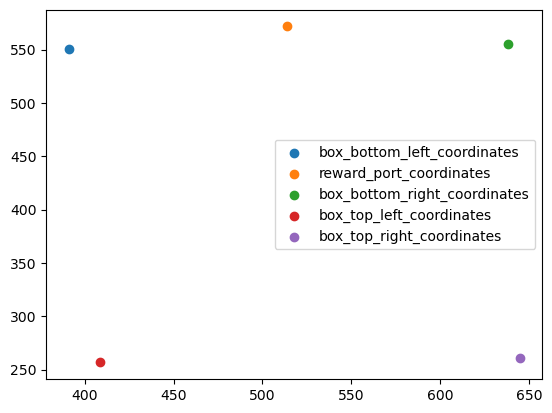

In [28]:
fig, ax = plt.subplots()

for index, row in tone_start_df.iterrows():
    for corner in corner_columns:
        plt.scatter(row[corner][0], row[corner][1], label=corner)
    break
plt.legend()

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [29]:
tone_start_df["bottom_width"] = tone_start_df.apply(lambda row: row["box_bottom_right_coordinates"][0] - row["box_bottom_left_coordinates"][0], axis=1)
tone_start_df["top_width"] = tone_start_df.apply(lambda row: row["box_top_right_coordinates"][0] - row["box_top_left_coordinates"][0], axis=1)

In [30]:
tone_start_df["right_height"] = tone_start_df.apply(lambda row: row["box_bottom_right_coordinates"][1] - row["box_top_right_coordinates"][1], axis=1)
tone_start_df["left_height"] = tone_start_df.apply(lambda row: row["box_bottom_left_coordinates"][1] - row["box_top_left_coordinates"][1], axis=1)

In [31]:
tone_start_df["average_height"] = tone_start_df.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
tone_start_df["average_width"] = tone_start_df.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [32]:
tone_start_df["width_ratio"] = 29.5 / tone_start_df["average_width"]
tone_start_df["height_ratio"] = 24 / tone_start_df["average_height"]


In [33]:
tone_start_df["reward_port_scaled"] = tone_start_df.apply(lambda row: np.array([row["reward_port_coordinates"][0] * row["width_ratio"], row["reward_port_coordinates"][1] * row["height_ratio"]]), axis=1)

In [34]:
tone_start_df["reward_port_scaled"]

0        [62.65767561559346, 46.6450642268789]
1      [44.79031206327622, 38.095121316373195]
2       [44.42939704940567, 35.56550022490564]
3      [62.66437903191042, 46.457593353668756]
4       [44.67155311688311, 37.96517782319081]
5       [43.48033926710607, 35.45305995884919]
6       [63.67403573088538, 47.18483629837384]
7      [43.50130361232485, 35.355649768653635]
8      [63.61830704527882, 47.078440172566104]
9       [64.53216327469285, 47.11044009374468]
10       [63.43516068508019, 47.6202483305839]
11       [62.85596760361868, 46.5217960004979]
12      [44.98362245572794, 37.64878595279556]
13      [65.42517992066077, 46.61455513415089]
14     [63.046091498234816, 46.91265128411644]
15      [63.55260453352851, 46.89055487864883]
17    [63.627820961484495, 45.886329355603685]
18     [43.099918367994746, 35.61912482253337]
19       [64.1506118178146, 47.81908162396559]
20    [44.148772051313195, 35.101527543757406]
21      [65.32806162465717, 47.14667016127896]
22      [44.6

# Getting the coordinates of each mouse

- Function that fills missing coordinates by interpolating

In [35]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y


In [36]:
body_part_node_names = get_sleap_coordinates(all_pose_estimation_h5[0])[1]

In [37]:
body_part_node_names

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

- Function that scales each coordinate

In [38]:
def scale_coordinates(row, coordinate_col, height_ratio_col="height_ratio", width_ratio_col="width_ratio"):
    """
    """
    return np.dstack((row[coordinate_col][:,:,0] * row[width_ratio_col], row[coordinate_col][:,:,1] * row[height_ratio_col]))


In [39]:
for num in range(2):
    tone_start_df["pose_estimation_subj_{}_original_coordinates".format(num + 1)] = tone_start_df["pose_estimation_file"].apply(lambda x: fill_missing(get_sleap_coordinates(x)[0][:,:,:,num]))
    tone_start_df["pose_estimation_subj_{}_scaled_coordinates".format(num + 1)] = tone_start_df.apply(lambda row: scale_coordinates(row, "pose_estimation_subj_{}_original_coordinates".format(num + 1)), axis=1)     
    tone_start_df["pose_estimation_subj_{}_thorax_coordinates".format(num + 1)] = tone_start_df["pose_estimation_subj_{}_scaled_coordinates".format(num + 1)].apply(lambda x: x[:,4,:])
    tone_start_df["pose_estimation_subj_{}_name".format(num + 1)] = tone_start_df["pose_estimation_file"].apply(lambda x: get_sleap_coordinates(x)[2][num])


In [40]:
tone_start_df.head()

,File Name,Frame Start,FPS,Strain,subj_1,subj_2,all_subj,all_tone_frame,corner_file,pose_estimation_file,...,height_ratio,reward_port_scaled,pose_estimation_subj_1_original_coordinates,pose_estimation_subj_1_scaled_coordinates,pose_estimation_subj_1_thorax_coordinates,pose_estimation_subj_1_name,pose_estimation_subj_2_original_coordinates,pose_estimation_subj_2_scaled_coordinates,pose_estimation_subj_2_thorax_coordinates,pose_estimation_subj_2_name
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,1.1,1.2,"(1.1, 1.2)","[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,0.081602,"[62.65767561559346, 46.6450642268789]","[[[520.4361572265625, 564.3905639648438], [499...","[[[63.45613955133118, 46.055351719549506], [60...","[[64.2990287199225, 44.027829978141874], [64.2...",1.1,"[[[368.9432067871094, 284.2481384277344], [392...","[[[44.98479072084644, 23.195192880177135], [47...","[[47.306155506552955, 24.141277551998048], [47...",1.2
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,1.3,1.4,"(1.3, 1.4)","[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,0.057763,"[44.79031206327622, 38.095121316373195]","[[[680.289306640625, 400.05560302734375], [676...","[[[58.644644060289274, 23.108399542698006], [5...","[[61.7094413419158, 22.198077497602327], [61.7...",1.3,"[[[531.3592529296875, 648.0527954101562], [499...","[[[45.80606214447569, 37.43345376936677], [43....","[[46.209723992701065, 34.683338490517976], [46...",1.4
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2.1,2.2,"(2.1, 2.2)","[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,0.057216,"[44.42939704940567, 35.56550022490564]","[[[315.74310302734375, 508.35687255859375], [3...","[[[27.565068021130507, 29.086254855981128], [2...","[[30.34017396475596, 30.427972245799346], [30....",2.1,"[[[520.195556640625, 616.1532592773438], [499....","[[[45.41421733556245, 35.25395582729842], [43....","[[47.534636695053486, 32.74008833373921], [47....",2.2
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,2.2,2.4,"(2.2, 2.4)","[2138, 4538, 7238, 9638, 11888, 14888, 17738, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,0.081519,"[62.66437903191042, 46.457593353668756]","[[[563.5345458984375, 584.265380859375], [552....","[[[68.96148146275858, 47.628461715267704], [67...","[[71.41175226058016, 45.614624361532364], [71....",2.2,"[[[383.81134033203125, 507.93603515625], [387....","[[[46.96819178903383, 41.40620477746066], [47....","[[50.947502939058204, 41.122758181192154], [50...",2.4
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,2.1,2.3,"(2.1, 2.3)","[2127, 4527, 7227, 9627, 11877, 14877, 17727, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,0.057666,"[44.67155311688311, 37.96517782319081]","[[[352.04791259765625, 239.75645446777344], [3...","[[[30.180921336474817, 13.825768374929051], [3...","[[35.329769344397896, 13.176087411670519], [35...",2.1,"[[[440.73870849609375, 235.83706665039062], [4...","[[[37.784346434294605, 13.599753403799516], [3...","[[36.037506728469545, 14.767165547980444], [36...",2.3


In [41]:
tone_start_df["pose_estimation_subj_1_thorax_coordinates"].iloc[0].shape

(55952, 2)

# Calculating the distance from thorax to reward port

In [42]:
tone_start_df["thorax_to_reward_port_distance_subj_1"] = tone_start_df.apply(lambda row: np.linalg.norm(row["pose_estimation_subj_1_thorax_coordinates"] - row["reward_port_scaled"], axis=1), axis=1)
tone_start_df["thorax_to_reward_port_distance_subj_2"] = tone_start_df.apply(lambda row: np.linalg.norm(row["pose_estimation_subj_2_thorax_coordinates"] - row["reward_port_scaled"], axis=1), axis=1)



In [43]:
frame_range = 20 * 30

In [44]:
tone_start_df["thorax_to_reward_port_tone_slices_subj_1"] = tone_start_df.apply(lambda row:  np.vstack([row["thorax_to_reward_port_distance_subj_1"][tone_frame-frame_range:tone_frame+frame_range] for tone_frame in row["all_tone_frame"] if tone_frame <= row["thorax_to_reward_port_distance_subj_1"].shape[0]]), axis=1)
tone_start_df["thorax_to_reward_port_tone_slices_subj_2"] = tone_start_df.apply(lambda row:  np.vstack([row["thorax_to_reward_port_distance_subj_2"][tone_frame-frame_range:tone_frame+frame_range] for tone_frame in row["all_tone_frame"] if tone_frame <= row["thorax_to_reward_port_distance_subj_2"].shape[0]]), axis=1)


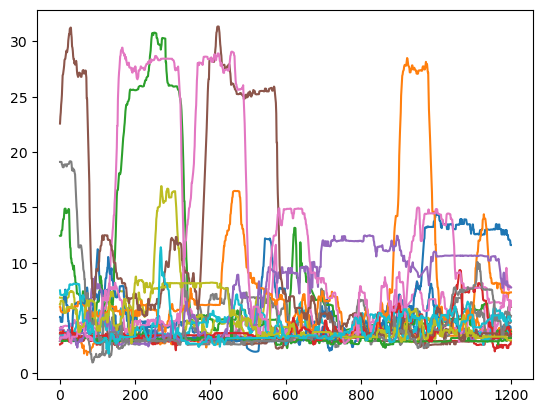

In [45]:
# Iterate over each row in the array
for i, row in enumerate(tone_start_df["thorax_to_reward_port_tone_slices_subj_1"].iloc[0]):
    # Plot the row data
    plt.plot(row, label=f'Line {i+1}')



# Averaging across trials

In [46]:
tone_start_df["thorax_to_reward_port_tone_trial_average_subj_1"] = tone_start_df["thorax_to_reward_port_tone_slices_subj_1"].apply(lambda x: np.mean(x, axis=0))
tone_start_df["thorax_to_reward_port_tone_trial_average_subj_2"] = tone_start_df["thorax_to_reward_port_tone_slices_subj_2"].apply(lambda x: np.mean(x, axis=0))

In [ ]:
# Iterate over each row in the array
for i, row in enumerate(tone_start_df["thorax_to_reward_port_tone_slices_subj_1"].iloc[0]):
    # Plot the row data
    plt.plot(row, label=f'Line {i+1}')

- TODO: Combine subject 1 and 2 data

In [47]:
c57_mean_distance = np.mean(tone_start_df[tone_start_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj_1"], axis=0)
cd1_mean_distance = np.mean(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"], axis=0)
# c57_sem_distance = np.std(tone_start_df[tone_start_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj_1"].to_list(), axis=0)
# cd1_sem_distance = np.std(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].to_list(), axis=0)
cd1_sem_distance = np.std(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].to_list(), axis=0) / np.sqrt(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].iloc[0].shape[0])  
c57_sem_distance = np.std(tone_start_df[tone_start_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj_1"].to_list(), axis=0) / np.sqrt(tone_start_df[tone_start_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj_1"].iloc[0].shape[0])  

In [48]:
tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].iloc[0].shape

(1200,)

In [49]:
np.sqrt(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].shape[0])  

4.0

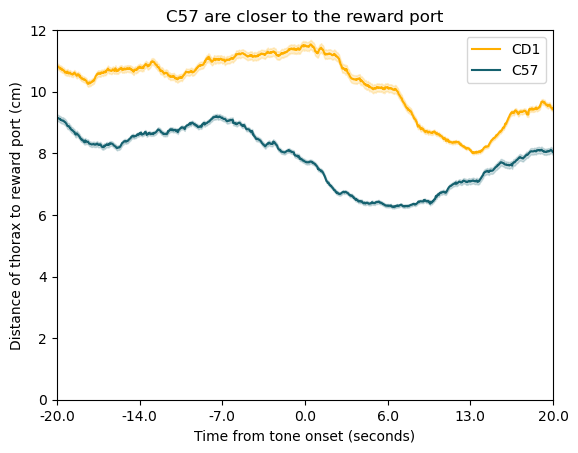

In [50]:
# Add shading for the standard error
plt.plot(cd1_mean_distance, color="#ffaf00", label="CD1")
plt.fill_between(range(len(cd1_mean_distance)), cd1_mean_distance - cd1_sem_distance, cd1_mean_distance + cd1_sem_distance, color="#ffaf00", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_mean_distance, color="#15616f", label="C57")
plt.fill_between(range(len(c57_mean_distance)), c57_mean_distance - c57_sem_distance, c57_mean_distance + c57_sem_distance, color="#15616f", alpha=0.2)
plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)
plt.ylim(0, 12)
plt.title("C57 are closer to the reward port")

plt.legend()

# Adding the win and loss information

# Incorporating Winning and Losing

In [51]:
rc_outcome_df = pd.read_excel("./data/iwata_pilot_3_reward_competition.xlsx")

In [52]:
rc_outcome_df["subj_1"] = rc_outcome_df["Match"].apply(lambda x: sorted([num.strip() for num in x.split("vs")])[0])
rc_outcome_df["subj_2"] = rc_outcome_df["Match"].apply(lambda x: sorted([num.strip() for num in x.split("vs")])[1])
rc_outcome_df["all_subj"] = rc_outcome_df.apply(lambda x: tuple(sorted([x["subj_1"], x["subj_2"]])) , axis=1)

In [53]:
rc_outcome_df

,Date,Cage,Box,Match,Scorer,Trial 1 Winner,Trial 2 Winner,Trial 3 Winner,Trial 4 Winner,Trial 5 Winner,...,Trial 16 Winner,Trial 17 Winner,Trial 18 Winner,Trial 19 Winner,Mouse 1 Wins,Mouse 2 Wins,Ties,subj_1,subj_2,all_subj
0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,1.1,1.2,1.2,1.1,tie,...,1.2,1.2,1.2,1.2,NaN,NaN,NaN,1.1,1.2,"(1.1, 1.2)"
1,2022-10-03,1,2,1.3 vs 1.4,Jocelyn,1.3,1.4,1.3,1.4,1.4,...,1.3,1.3,1.4,tie,NaN,NaN,NaN,1.3,1.4,"(1.3, 1.4)"
2,2022-10-03,2,3,2.1 vs 2.2,Jocelyn,2.2,2.1,2.1,2.1,2.1,...,2.2,2.1,2.1,2.2,NaN,NaN,NaN,2.1,2.2,"(2.1, 2.2)"
3,2022-10-03,2,4,2.3 vs 2.4,Jocelyn,2.4,2.4,2.4,2.3,2.4,...,2.4,2.4,2.4,2.3,NaN,NaN,NaN,2.3,2.4,"(2.3, 2.4)"
4,2022-10-03,3,1,3.1 vs 3.2,Meghan,3.2,3.1,3.1,3.2,3.2,...,3.1,3.1,3.1,3.1,NaN,NaN,NaN,3.1,3.2,"(3.1, 3.2)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2022-10-04,3,4,3.1vs3.2,Leo,3.2,3.2,3.2,3.1,3.1,...,3.2,3.2,3.2,3.1,NaN,NaN,NaN,3.1,3.2,"(3.1, 3.2)"
68,2022-10-04,2,1,2.3vs2.4,Aidan,2.4,2.3,2.3,2.3,2.3,...,2.3,2.3,2.3,tie,16.0,2.0,1.0,2.3,2.4,"(2.3, 2.4)"
69,2022-10-04,2,2,2.1vs2.2,Albert,2.2,2.2,2.2,tie,2.2,...,2.2,2.2,2.2,2.2,0.0,17.0,2.0,2.1,2.2,"(2.1, 2.2)"
70,2022-10-04,1,3,1.3vs1.4,Aidan,1.3,1.3,1.4,1.4,1.4,...,1.3,tie,tie,1.3,9.0,6.0,3.0,1.3,1.4,"(1.3, 1.4)"


In [54]:
rc_outcome_df["subj_1"].unique()

array(['1.1', '1.3', '2.1', '2.3', '3.1', '3.3', '4.1', '4.3', '5.1',
       '5.3', '6.1', '6.3', '2.2', '1.2', '4.2', '3.2', '6.2', '5.2'],
      dtype=object)

In [55]:
rc_outcome_df["subj_1"].unique()

array(['1.1', '1.3', '2.1', '2.3', '3.1', '3.3', '4.1', '4.3', '5.1',
       '5.3', '6.1', '6.3', '2.2', '1.2', '4.2', '3.2', '6.2', '5.2'],
      dtype=object)

In [56]:
raise ValueError()

ValueError: 

In [ ]:
np.mean(tone_start_df["thorax_to_reward_port_tone_slices_subj_1"].iloc[0], axis=0)


In [ ]:
plt.plot(cd1_mean_distance)

In [ ]:
for num in tone_start_df["thorax_to_reward_port_tone_slices_subj_1"]:
    print(num.shape)

In [ ]:
 np.vstack([arr[start:end] for start, end in ranges])

In [ ]:
((23)**2 + (29.5)**2)**0.5

In [ ]:
tone_start_df["thorax_to_reward_port_distance_subj_1"].iloc[0].shape

In [ ]:
for num in range(2):
#     print(num)

In [ ]:
tone_start_df["pose_estimation_subj_2_thorax_coordinates"].iloc[0]

In [ ]:
tone_start_df["pose_estimation_subj_1_thorax_coordinates"] = 

In [ ]:
tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,1] * tone_start_df["height_ratio"].iloc[0]

In [ ]:
(tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,1] * tone_start_df["height_ratio"].iloc[0]).shape

In [ ]:
np.dstack((tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,0] * tone_start_df["width_ratio"].iloc[0], tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,1] * tone_start_df["height_ratio"].iloc[0]))

In [ ]:
tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,:]

3000: the number of frames;

13: the number of nodes in the skeleton (we’ve also loaded and displayed the node_names dataset with the names of these 13 nodes);

2: for the x and y coordinates;

2: the number of distinct animal identities which were found (we have 2 flies in the video clip and they were tracked perfectly, so we ended up with exactly 2 track, but there may be more tracks than animals if tracking didn’t work as well).

In [ ]:
tone_start_df["pose_estimation_subj_1"] = 
tone_start_df["pose_estimation_subj_1"] = 

In [ ]:
node_names

In [ ]:
tone_start_df["pose_estimation_file"].apply(lambda x: get_sleap_coordinates(x)[0][0,index,:,0])

In [ ]:
for index, node in enumerate(corner_node_names):
    tone_start_df["{}_coordinates".format(node)] = tone_start_df["pose_estimation_file"].apply(lambda x: get_sleap_coordinates(x)[0][0,index,:,0])

# Calculate Distance from Thorax to Reward Port

In [ ]:
for index, node in enumerate(corner_node_names):
    tone_start_df["{}_coordinates".format(node)] = tone_start_df["corner_file"].apply(lambda x: get_sleap_coordinates(x)[0][0,index,:,0])

In [ ]:
raise ValueError()

- Calculating Horizontal and Vertical Distances

In [ ]:
tone_start_df["horizontal_length"] = tone_start_df.apply(lambda row: row["box_bottom_left_coordinates"][])

In [ ]:
filename = all_corner_h5[0]

In [ ]:

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

In [ ]:
locations[0,1,0,0]

In [ ]:
locations[0,1,1,0]

In [ ]:
for index, row in tone_start_df.iterrows():
    print(row["corner_file"])
    